이미지 전처리

In [1]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab # skimage: 이미지를 처리, rgb2lab: 이미지를 LAB이미지로 변환
from skimage.transform import resize # resize: 이미지 조정
from collections import namedtuple # namedtuple: 이름으로 접근 가능한 튜플
import numpy as np

np.random.seed(101) # seed: 정해진 난수 배열 주소 -> 시드 101 -> 난수 -> 같은 난수 배열
%matplotlib inline 

N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

Dataset = namedtuple("dataset", ["X", "y"]) # namedtuple 구조 정의

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis = 0).astype(np.float32)

# 이미지 파일 폴더경로, 43, (32,32)
def read_databse_ppm(rootpath, n_labels, resize_to):
	images = [] 
	labels = []
	#c가 0~ 라벨 개수 - 1 까지 반복
	for c in range(n_labels):
		# format c -> 0 ~ 42, '05d' 빈자리 0으로 채워진 5자리 십진수
		# Images/00000/
		full_path = rootpath + '/' + format(c, "05d") + "/"
  
		# glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 변환
		# 각 폴더[ex) 00001]의 이미지 만큼 반복
		for img_name in glob.glob(full_path + "*.ppm"):
			# imread 이미지 파일을 읽는 것, astype -> 타입변환 -> 이미지 파일 내부 배열(픽셀) -> float32 실수로
			img = plt.imread(img_name).astype(np.float32)
   
			# rgb2lab rgb->lab
			# 픽셀 값(byte) -> 0~255 / 255.0 -> 0~1 사이의 소수
			img = rgb2lab(img / 255.0)[:, :, 0]
			if resize_to:
				img = resize(img, resize_to, mode = "reflect")
    
			label = np.zeros((n_labels, ), dtype=np.float32)
			label[c] = 1.0
			
			images.append(img.astype(np.float32))
			labels.append(label)
   
	# matrix 2차원 특성을 유지하는 특수화된 2차원 배열
	return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

dataset = read_databse_ppm("GTSRB/Final_Training/Images", N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)


(39209, 32, 32, 1)
(39209, 43)


In [2]:
# train_test_split(분할시킬배열, 테스셋비율, 셔플할때 시드값: 75%, 25%)
# dataset.X.shape[0] -> 39209
# random_state -> 매번 실행할때마다 트레이닝 이미지와 테스트 이미지를 고정
# return 트레이닝 idx 배열, 테스트 idx 배열
from sklearn.model_selection import train_test_split 

# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#idx_train [0, 1, 2, 3, 4, 5, 6, 7]
#idx_test [8, 9]
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size= 0.25, random_state=101)

# idx_train 해당되는 이미지 정보만 -> X_train
X_train = dataset.X[idx_train, :, :, :]
# idx_test 해당되는 이미지 정보만 -> X_test
X_test = dataset.X[idx_test, :, :, :]
# idx_train 해당되는 label 정보만 -> y_train
y_train = dataset.y[idx_train, :]
# idx_test 해당되는 label 정보만 -> y_test
y_test = dataset.y[idx_test, :]

print(X_train.shape)
print(y_train.shape)

(29406, 32, 32, 1)
(29406, 43)


모델 훈련 및 예측

In [3]:
# 셔플 함수 X_train, y_trian, 10000, true
def minibatcher(X, y, batch_size, shuffle):
    # assert 뒤의 조건이 만족하지 않으면 오류 출력
    assert X.shape[0] == y.shape[0]
    
    # 샘플 개수
    n_samples = X.shape[0]
    
    if shuffle:
        # idx = 0~n_samples-1 까지의 숫자를 랜덤하게 배치한 n_samples크기의 배열
        idx = np.random.permutation(n_samples)
    else:
        # idx -> [0, 1, 2......n_samples-1]
        idx = list(range(n_samples))
        
    # n_samples 39209 / 10000
    # 4번 반복 k 0 ~ 3
    # ceil -> 올림수 0.0 -> 0, 0.1 -> 1
    for k in range(int(np.ceil(n_samples/batch_size))):
        # k 0, from 0, to 10000
        # k 1, from 10000, to 20000
        from_idx = k*batch_size
        to_idx = (k+1)*batch_size
        yield X[idx[from_idx : to_idx], :, :, :], y[idx[from_idx : to_idx], :]
        
for mb in minibatcher(X_train, y_train, 10000, True):
    print(mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


In [4]:
import tensorflow as tf

def fc_no_activation_layer(in_tensors, n_units):
    w = tf.get_variable('fc_W',
    [in_tensors.get_shape()[1], n_units],
    tf.float32,
    tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("fc_B",
        [n_units, ],
        tf.float32,
        tf.constant_initializer(0.0))
    return tf.matmul(in_tensors, w) + b

def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

def conv_layer(in_tensors, kernel_size, n_units):
    w = tf.get_variable("conv_W",
        [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
        tf.float32,
        tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("conv_B",
        [n_units, ],
        tf.float32,
        tf.constant_initializer(0.0))
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 1, 1, 1], "SAME") + b)

def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], "SAME")

def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)
    
def model(in_tensors, is_training):
    with tf.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
        
    with tf.variable_scope("l2"):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
        
    with tf.variable_scope("flatten"):
        l2_out_flat = tf.layers.flatten(l2_out)
        
    with tf.variable_scope("l3"):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
        
    with tf.variable_scope("Out"):
        out_tensors = fc_no_activation_layer(l3_out, N_CLASSES)
    
    return out_tensors

c:\ProgramData\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\ProgramData\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\ProgramData\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\ProgramData\Anaconda3\envs\python36\lib\site-packages\tensorf

Epoch= 0
 train_loss_score= 3.879225
Epoch= 1
 train_loss_score= 0.58826494
Epoch= 2
 train_loss_score= 0.2782147
Epoch= 3
 train_loss_score= 0.17054921
Epoch= 4
 train_loss_score= 0.12501526
Epoch= 5
 train_loss_score= 0.09577163
Epoch= 6
 train_loss_score= 0.07709637
Epoch= 7
 train_loss_score= 0.06451096
Epoch= 8
 train_loss_score= 0.05673416
Epoch= 9
 train_loss_score= 0.046216816
TEST SET PERFORMANCE
 test_loss_score= 0.051092345
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        67
           1       0.97      0.99      0.98       539
           2       0.97      0.98      0.98       558
           3       1.00      0.95      0.98       364
           4       1.00      0.99      1.00       487
           5       0.99      0.97      0.98       479
           6       1.00      1.00      1.00       105
           7       0.99      0.96      0.98       364
           8       0.99      0.99      0.99       340
           9       0

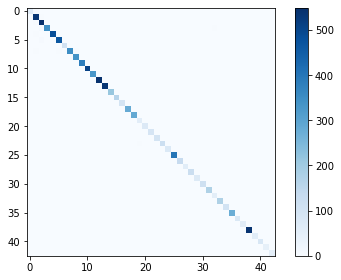

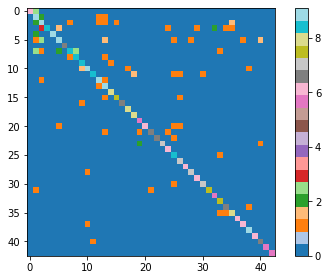

In [6]:
from sklearn.metrics import classification_report, confusion_matrix


def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):

  in_X_tensors_batch = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
  in_y_tensors_batch = tf.placeholder(tf.float32, shape = (None, N_CLASSES))
  is_training = tf.placeholder(tf.bool)

  logits = model(in_X_tensors_batch, is_training)
  out_y_pred = tf.nn.softmax(logits)
  loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
  loss = tf.reduce_mean(loss_score)
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

  with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    for epoch in range(max_epochs):
      print("Epoch=", epoch)
      tf_score = []
      
      for mb in minibatcher(X_train, y_train, batch_size, shuffle = True):
        tf_output = session.run([optimizer, loss], 
                                feed_dict = {in_X_tensors_batch : mb[0], 
                                             in_y_tensors_batch : mb[1],
                                             is_training : True})
      
        tf_score.append(tf_output[1])
      print(" train_loss_score=", np.mean(tf_score))
    
    # after the training is done, time to test it on the test set
    print("TEST SET PERFORMANCE")
    y_test_pred, test_loss  = session.run([out_y_pred, loss], 
                                          feed_dict = {in_X_tensors_batch : X_test, 
                                                       in_y_tensors_batch : y_test,
                                                       is_training : False})
    
    print(" test_loss_score=", test_loss)
    y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
    y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
    print(classification_report(y_test_true_classified, y_test_pred_classified))
    
    cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # And the log2 version, to enphasize the misclassifications
    plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
    plt.colorbar()
    plt.tight_layout()
    plt.show()


tf.reset_default_graph()
train_model(X_train, y_train, X_test, y_test, 0.001, 10, 256)